In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [4]:
non_stat_series = pd.read_csv("/Users/max/Downloads/Архив/Series/monthly-boston-armed-robberies-j.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


/Users/max/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


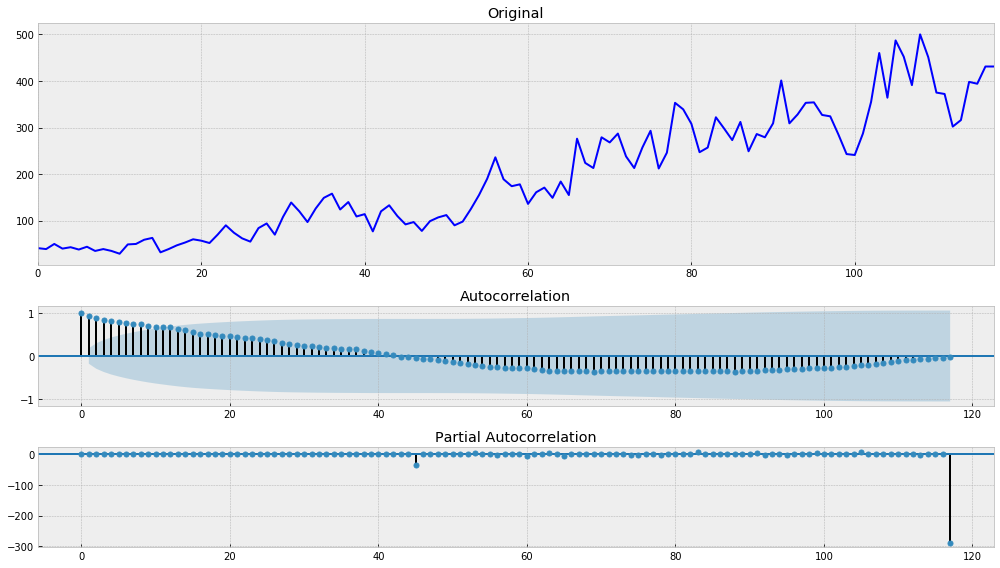

In [5]:
tsplot(non_stat_series)

In [6]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [7]:
def plot_dema(alpha, beta):
    dema = double_ema(non_stat_series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(non_stat_series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

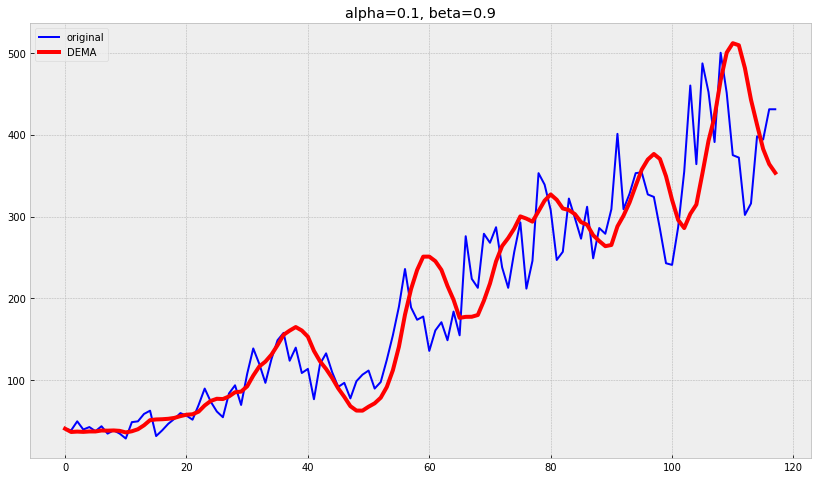

In [8]:
plot_dema(0.1, 0.9)

In [9]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [10]:
def mse(X):
    alpha, beta = X
    result = double_ema(non_stat_series, alpha, beta)
    error = mean_squared_error(result, non_stat_series)
    return error

In [11]:
opt = minimize(mse, x0=[0.1,0.1], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [12]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 1.183003133456858
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.04867243e-05, -3.97593070e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 10
   status: 0
  success: True
        x: array([0.99789467, 0.00653549])


In [13]:
def plot_dema1(alpha, beta):
    dema = double_ema(non_stat_series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(non_stat_series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='3', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [14]:
alpha_opt, beta_opt

(0.9978946740791, 0.006535488885065621)

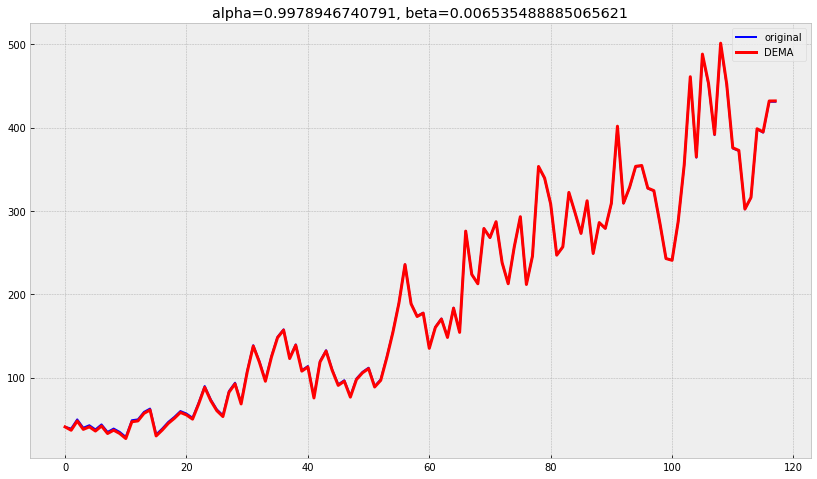

In [15]:
plot_dema1(alpha_opt, beta_opt)

In [16]:
mse([alpha_opt, beta_opt]) # error

1.183003133456858

Ряд несложный, нет сезонности, есть тренд. Выбрал Двойное экспоненциальное сглаживание.

In [17]:
series = pd.read_csv("/Users/max/Downloads/Архив/Series/monthly-boston-armed-robberies-j.csv")['Count']

In [18]:
series = boxcox(series, 0)

In [19]:
stat_series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


/Users/max/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


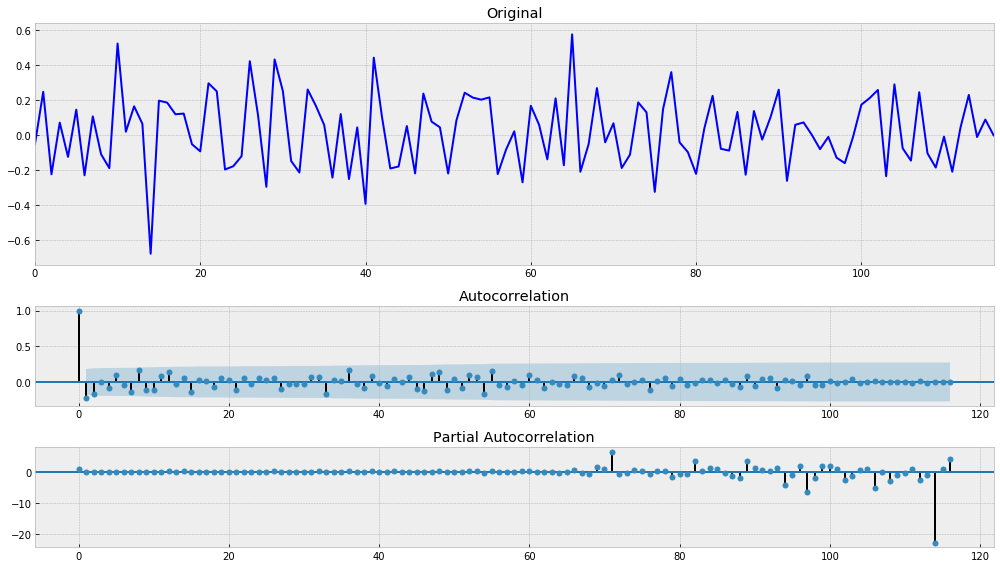

In [20]:
tsplot(stat_series)

In [21]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [22]:
ema = exponential_moving_average(stat_series, 0.9)

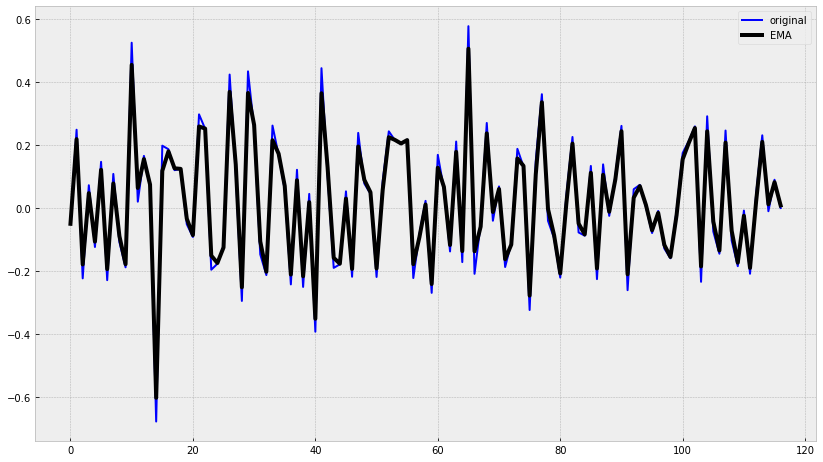

In [23]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(stat_series, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [24]:
def mseV2(X):
    alpha = X
    result = exponential_moving_average(stat_series, alpha)
    error = mean_squared_error(result, stat_series)
    return error

In [25]:
mseV2(0.9)

0.0009434080651297507

Выбрал экспоненциальное сглаживание, так как ряд не имеет тренда.